# **Bone Break Image Classification**

This notebook will serve as a development environment for the development of [Bone Break Image Classification](https://www.kaggle.com/datasets/pkdarabi/bone-break-classification-image-dataset) dataset for my CCS 229 - Intelligent Systems Course.

In this notebook, we will have the following objectives:
- Load the dataset with the `Dataset` object
- Plot images from the dataset for a glance of the dataset
- Define preprocessing and augmentation steps
- Define PyTorch CNN class architecture using `nn.Module`
- Define and prepare necessary hyperparameters for model training
- Train the model with *n* epochs
- Evaluate the model and plot its performance with accuracy and loss
- Save the model with `torch.save` as a `.pth` file
- Load the model once again to perform a sample prediction

In [3]:
import torch
from torchvision import datasets, models
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch import nn, optim
from torchvision.transforms import v2
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from datetime import datetime

In [4]:
dataset_path = Path('../../data/')
full_dataset = datasets.ImageFolder(root=dataset_path)
idx_labels = full_dataset.class_to_idx

In [5]:
idx_labels

{'Avulsion fracture': 0,
 'Comminuted fracture': 1,
 'Fracture Dislocation': 2,
 'Greenstick fracture': 3,
 'Hairline Fracture': 4,
 'Impacted fracture': 5,
 'Longitudinal fracture': 6,
 'Oblique fracture': 7,
 'Pathological fracture': 8,
 'Spiral Fracture': 9}

In [6]:
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

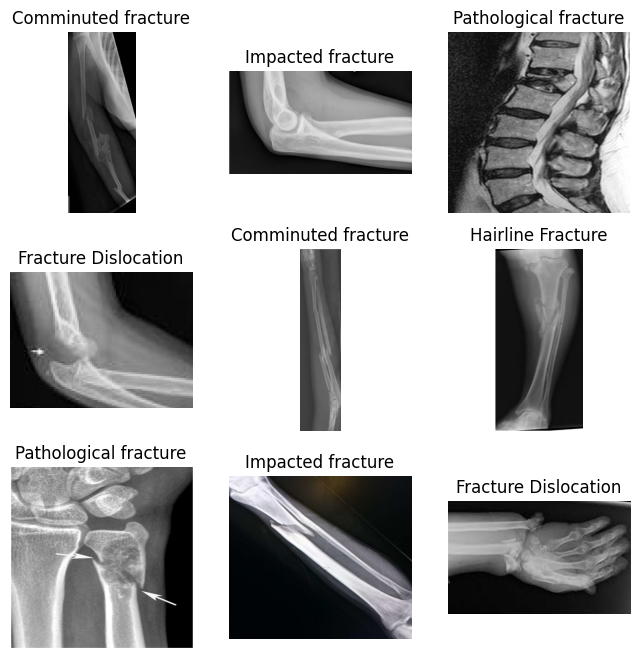

In [7]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(list(idx_labels.keys())[list(idx_labels.values()).index(label)])
    plt.axis("off")
    plt.imshow(img)
plt.show()

In [8]:
# defining transformation pipeline
transform = v2.Compose([
    v2.Grayscale(num_output_channels=3),
    v2.RandomResizedCrop(224, scale=(0.8, 1.0)),
    v2.RandomHorizontalFlip(),
    v2.RandomRotation(10),
    v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Apply transforms
train_dataset.dataset.transform = transform
test_dataset.dataset.transform = transform

In [9]:
# --- DataLoaders ---
BATCH_SIZE = 64
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=0, pin_memory=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=0, pin_memory=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.8208283].


Feature batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64])


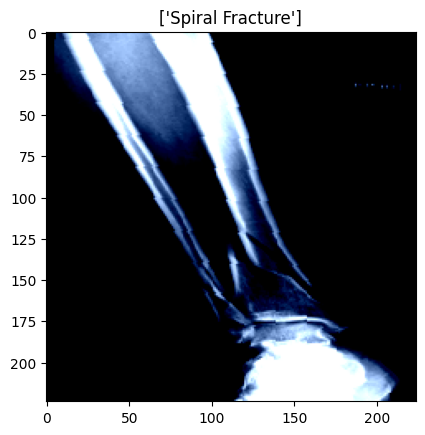

In [10]:
# Sample display image and label
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img.permute(1,2,0))
plt.title([key for key, val in idx_labels.items() if val == label])
plt.show()

In [11]:
model = models.mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 10)
# model = models.resnet50(pretrained=True)
# model.fc = nn.Linear(model.fc.in_features, 10)
device = torch.device("cpu")
model.to(device)

c:\Users\admin\Desktop\Classes\2nd sem\Intelligent Systems\BreakingBone\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\admin\Desktop\Classes\2nd sem\Intelligent Systems\BreakingBone\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [12]:
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3)

In [13]:
def compute_accuracy(preds, labels):
    _, pred_labels = preds.max(1)
    return (pred_labels == labels).sum().item() / labels.size(0)

In [14]:
def train_one_epoch(epoch, model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(dataloader, desc=f"Epoch {epoch+1} [Train]", leave=False)
    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        acc = compute_accuracy(outputs, labels)
        total_loss += loss.item() * inputs.size(0)
        correct += acc * inputs.size(0)
        total += inputs.size(0)
        
        loop.set_postfix(loss=loss.item(), acc=acc)

    return total_loss / total, correct / total

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            acc = compute_accuracy(outputs, labels)

            total_loss += loss.item() * inputs.size(0)
            correct += acc * inputs.size(0)
            total += inputs.size(0)

    return total_loss / total, correct / total

In [12]:
MODEL_LOG = Path(f"./logs/run_{datetime.now():%Y%m%d_%H%M%S}")
MODEL_LOG.mkdir(parents=True, exist_ok=True)
CSV_LOG_PATH = MODEL_LOG / "training_log.csv"

log_df = pd.DataFrame(columns=['epoch', 'phase', 'train_loss', 'train_acc', 'val_loss', 'val_acc', 'lr'])

In [13]:
best_val_acc = 0.0

# Freeze feature extractor (mobilenet)
# for param in model.features.parameters():
#     param.requires_grad = False

for name, param in model.named_parameters():
    if "fc" not in name:
        param.requires_grad = False

EPOCHS_FROZEN = 15
EPOCHS_TOTAL = EPOCHS_FROZEN + 10

best_val_loss = float('inf')
patience = 50
trigger_times = 0

print("🔒 Training classifier head only")
for epoch in range(EPOCHS_FROZEN):
    train_loss, train_acc = train_one_epoch(epoch, model, train_dataloader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, test_dataloader, criterion, device)
    scheduler.step(val_loss)
    
    lr = optimizer.param_groups[0]['lr']
    log_df.loc[len(log_df)] = [epoch + 1, 'phase1', train_loss, train_acc, val_loss, val_acc, lr]
    print(f"P1: Epoch {epoch+1} | Train Acc: {train_acc:.2%} | Train Loss: {train_loss:.2} | Test Acc: {val_acc:.2%} | Test Loss: {val_loss:.2} | LR: {lr}")
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), MODEL_LOG / f"p1_e{epoch+1}_best_model.pth")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping!")
            break

# Unfreeze all layers
optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-5)
for param in model.parameters():
    param.requires_grad = True

print("\n🔓 Phase 2: Fine-tuning full model")
for epoch in range(EPOCHS_FROZEN, EPOCHS_TOTAL):
    train_loss, train_acc = train_one_epoch(epoch, model, train_dataloader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, test_dataloader, criterion, device)
    scheduler.step(val_loss)
    
    lr = optimizer.param_groups[0]['lr']
    log_df.loc[len(log_df)] = [epoch + 1, 'phase2', train_loss, train_acc, val_loss, val_acc, lr]
    print(f"P2: Epoch {epoch+1} | Train Acc: {train_acc:.2%} | Train Loss: {train_loss:.2} | Test Acc: {val_acc:.2%} | Test Loss: {val_loss:.2} | LR: {lr}")
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), MODEL_LOG / f"p2_e{epoch+1}_best_model.pth")
        
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping!")
            break

log_df.to_csv(CSV_LOG_PATH, index=False)
print(f"\n📑 Training complete. Best validation accuracy: {best_val_acc:.2%}")

🔒 Training classifier head only


P1: Epoch 1 | Train Acc: 12.18% | Train Loss: 2.3 | Test Acc: 15.04% | Test Loss: 2.3 | LR: 0.0003


P1: Epoch 2 | Train Acc: 16.83% | Train Loss: 2.2 | Test Acc: 16.81% | Test Loss: 2.3 | LR: 0.0003


P1: Epoch 3 | Train Acc: 19.27% | Train Loss: 2.2 | Test Acc: 19.91% | Test Loss: 2.2 | LR: 0.0003


P1: Epoch 4 | Train Acc: 24.58% | Train Loss: 2.2 | Test Acc: 24.34% | Test Loss: 2.2 | LR: 0.0003


P1: Epoch 5 | Train Acc: 26.69% | Train Loss: 2.1 | Test Acc: 20.35% | Test Loss: 2.2 | LR: 0.0003


P1: Epoch 6 | Train Acc: 28.35% | Train Loss: 2.1 | Test Acc: 20.80% | Test Loss: 2.1 | LR: 0.0003


P1: Epoch 7 | Train Acc: 30.34% | Train Loss: 2.1 | Test Acc: 19.91% | Test Loss: 2.1 | LR: 0.0003


P1: Epoch 8 | Train Acc: 28.68% | Train Loss: 2.1 | Test Acc: 24.78% | Test Loss: 2.1 | LR: 0.0003


P1: Epoch 9 | Train Acc: 32.56% | Train Loss: 2.0 | Test Acc: 22.57% | Test Loss: 2.1 | LR: 0.0003


P1: Epoch 10 | Train Acc: 31.67% | Train Loss: 2.0 | Test Acc: 24.34% | Test Loss: 2.1 | LR: 0.0003


P1: Epoch 11 | Train Acc: 32.67% | Train Loss: 2.0 | Test Acc: 26.11% | Test Loss: 2.1 | LR: 0.0003


P1: Epoch 12 | Train Acc: 35.55% | Train Loss: 2.0 | Test Acc: 24.34% | Test Loss: 2.1 | LR: 0.0003


P1: Epoch 13 | Train Acc: 32.89% | Train Loss: 2.0 | Test Acc: 26.11% | Test Loss: 2.0 | LR: 0.0003


P1: Epoch 14 | Train Acc: 35.33% | Train Loss: 1.9 | Test Acc: 28.32% | Test Loss: 2.0 | LR: 0.0003


P1: Epoch 15 | Train Acc: 34.44% | Train Loss: 1.9 | Test Acc: 24.34% | Test Loss: 2.1 | LR: 0.0003

🔓 Phase 2: Fine-tuning full model


P2: Epoch 16 | Train Acc: 38.10% | Train Loss: 1.9 | Test Acc: 26.99% | Test Loss: 2.0 | LR: 1e-05


P2: Epoch 17 | Train Acc: 40.09% | Train Loss: 1.8 | Test Acc: 26.11% | Test Loss: 2.0 | LR: 1e-05


P2: Epoch 18 | Train Acc: 44.19% | Train Loss: 1.7 | Test Acc: 31.86% | Test Loss: 1.9 | LR: 1e-05


P2: Epoch 19 | Train Acc: 44.63% | Train Loss: 1.7 | Test Acc: 33.19% | Test Loss: 1.9 | LR: 1e-05


P2: Epoch 20 | Train Acc: 46.73% | Train Loss: 1.6 | Test Acc: 30.09% | Test Loss: 1.9 | LR: 1e-05


P2: Epoch 21 | Train Acc: 50.28% | Train Loss: 1.6 | Test Acc: 33.19% | Test Loss: 1.9 | LR: 1e-05


P2: Epoch 22 | Train Acc: 53.93% | Train Loss: 1.5 | Test Acc: 36.28% | Test Loss: 1.8 | LR: 1e-05


P2: Epoch 23 | Train Acc: 51.94% | Train Loss: 1.5 | Test Acc: 35.84% | Test Loss: 1.8 | LR: 1e-05


P2: Epoch 24 | Train Acc: 56.70% | Train Loss: 1.4 | Test Acc: 35.84% | Test Loss: 1.8 | LR: 1e-05


P2: Epoch 25 | Train Acc: 57.70% | Train Loss: 1.4 | Test Acc: 37.61% | Test Loss: 1.8 | LR: 1e-05

📑 Training complete. Best validation accuracy: 37.61%


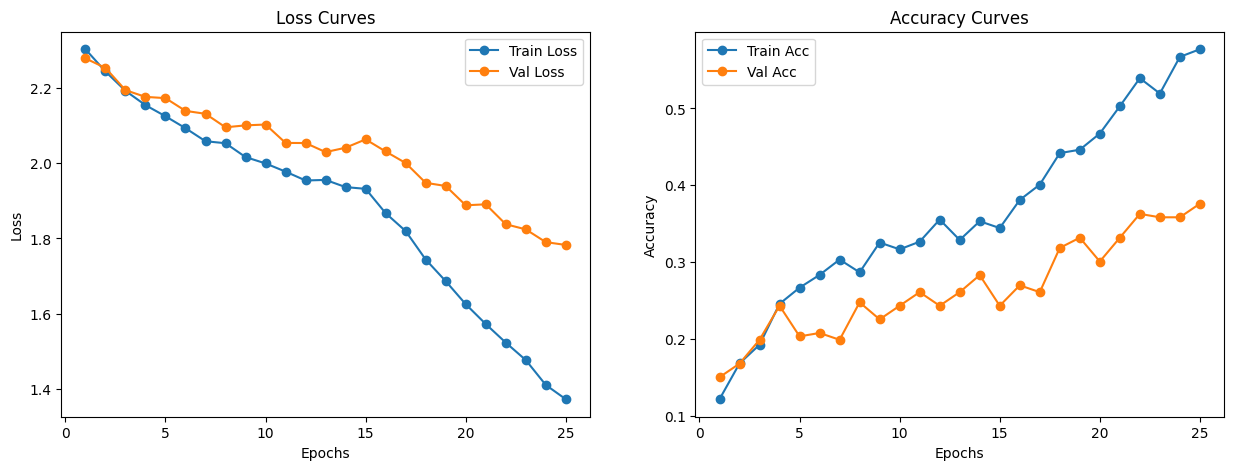

In [14]:
import matplotlib.pyplot as plt

# Assuming log_df contains your training logs
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(log_df['epoch'], log_df['train_loss'], label='Train Loss', marker='o')
ax1.plot(log_df['epoch'], log_df['val_loss'], label='Val Loss', marker='o')
ax1.set_title('Loss Curves')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Accuracy plot
ax2.plot(log_df['epoch'], log_df['train_acc'], label='Train Acc', marker='o')
ax2.plot(log_df['epoch'], log_df['val_acc'], label='Val Acc', marker='o')
ax2.set_title('Accuracy Curves')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.savefig(MODEL_LOG / "output.jpg")
plt.show()